In [61]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
import numpy as np 
import IPython
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
import dataloader as da
from sklearn.metrics import roc_curve 
os.getcwd()

'd:\\courses\\Weaning\\COM4520-Darwin-weaing-of-ventilators\\Transformers\\Model'

## Create LSTM module

In [62]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1, batch_size = 50, feature_size=10):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size).cuda()

        self.linear = nn.Linear(hidden_layer_size, output_size).cuda()

        self.hidden_cell = (torch.zeros(1,feature_size,self.hidden_layer_size).cuda(),
                            torch.zeros(1,feature_size,self.hidden_layer_size).cuda())
        self.batch_size = batch_size
        
        self.feature_size = feature_size
    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(self.batch_size, self.feature_size, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(self.batch_size, self.feature_size, -1))
        return predictions[:,:,-1]
    def reset(self):
        self.hidden_cell = (torch.zeros(1,self.feature_size,self.hidden_layer_size).cuda(),
                    torch.zeros(1,self.feature_size,self.hidden_layer_size).cuda())

### Create LSTM dataset

In [63]:
train_set = da.MyDataset('windows_df_360.csv',be_normalize=True)
x_train = train_set.x_train
x_test = train_set.x_test

d:\courses\Weaning\COM4520-Darwin-weaing-of-ventilators\Transformers\Model\dataloader.py:94: DtypeWarning: Columns (5,22) have mixed types.Specify dtype option on import or set low_memory=False.
  load_df,windows_size =load(file_name)
d:\courses\Weaning\COM4520-Darwin-weaing-of-ventilators\Transformers\Model\dataloader.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = normalized_data


### LSTM Training process

In [64]:
def LSTM_train(train_loader,optimizer,loss_function,model,epochs=5,batch_size=30,windows_size=300):
    record_epoch_loss=[]
    record_batch_loss=[]
    for i in range(epochs):
        for j, batch_windows in enumerate(train_loader):
            if batch_windows.shape[0]!=batch_size:
                continue
            optimizer.zero_grad()
            batch_loss=torch.tensor([]).cuda()
            for steps in range(windows_size-1):
                inputvector = batch_windows[:,steps,:]
                y_pred = model(inputvector)
                y_true = batch_windows[:,steps+1,:]
                single_loss = loss_function(y_pred, y_true)
                batch_loss=torch.cat((batch_loss,single_loss))
            mean_loss = batch_loss.mean()
            mean_loss.backward()
            record_batch_loss.append(torch.Tensor.cpu(mean_loss).detach().numpy())
            optimizer.step()
            model.reset()
            # print(record_batch_loss[-1])
        record_epoch_loss.append(np.mean(record_batch_loss[i*(j-1):(i+1)*(j-1)]))
    plt.plot(record_batch_loss)
    batch_loss.cpu()
    batch_windows.cpu()
    inputvector.cpu()
    single_loss.cpu()
    torch.cuda.empty_cache()
    print(record_epoch_loss)
    return(record_epoch_loss)

### Train LSTM Model

[0.077431716, 0.025975812, 0.008638093, 0.008329033, 0.00816041]


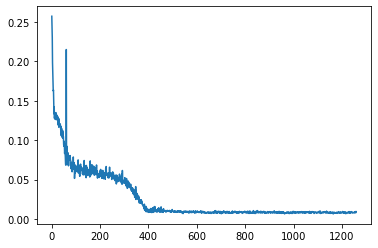

In [65]:
batch_size=30
model = LSTM(batch_size = batch_size, hidden_layer_size=100,feature_size=10).cuda()
loss_function = nn.L1Loss(reduction='none').cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 5
windows_size = 360
train_loader=DataLoader(x_train,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(x_test,batch_size=batch_size,shuffle=True)

random.seed(123)
np.random.seed(123)
torch.manual_seed(123)
lstm_epoch_loss=LSTM_train(train_loader,optimizer,loss_function,model)

### Predict for next 2 hours

[0.019827228, 0.026314594, 0.032381915, 0.0384551, 0.049623653, 0.06010492]


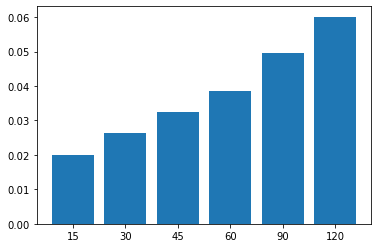

In [66]:
def loss_predict(dataloader,minutes=15):
    test_batch_loss=[]
    for j, batch_windows in enumerate(dataloader):
        if batch_windows.shape[0]!=batch_size:
            continue
        batch_loss=torch.tensor([]).cuda()
        start_min=np.random.randint(windows_size-minutes)
        for steps in range(start_min,start_min+minutes):
            if steps == start_min:
                inputvector = batch_windows[:,steps,:]
            else:
                inputvector = y_pred
            y_pred = model(inputvector)
            y_true = batch_windows[:,steps+1,:]
            single_loss = loss_function(y_pred, y_true)
            batch_loss=torch.cat((batch_loss,single_loss))
        mean_loss = batch_loss.mean()
        test_batch_loss.append(torch.Tensor.cpu(mean_loss).detach().numpy())
        model.reset()
    batch_loss.cpu()
    batch_windows.cpu()
    inputvector.cpu()
    single_loss.cpu()
    torch.cuda.empty_cache()
    return(np.mean(test_batch_loss))

predict_loss = []
predict_period=[15,30,45,60,90,120]
for period in predict_period:
    predict_loss.append(loss_predict(test_loader,minutes=period))
print(predict_loss)
plt.bar(range(len(predict_period)),predict_loss,tick_label=predict_period)
plt.show()

# Do classification

#### Grade the classification result

In [67]:
def performance_score(y_pred,y_true,print_performance=True):
    y_pred[y_pred>0.5]=1.
    y_pred[y_pred<=0.5]=0.
    y_pred=torch.Tensor.cpu(y_pred).detach().numpy()
    y_true=torch.Tensor.cpu(y_true).detach().numpy()
    performance_mark=[accuracy_score(y_true,y_pred),precision_score(y_true,y_pred,average='macro',zero_division=0)
                       ,recall_score(y_true,y_pred,average='macro'),f1_score(y_true,y_pred,average='macro')]
    if(print_performance):
        print('Accuracy:',performance_mark[0])
        print('Precision:', performance_mark[1])
        print('Recall:', performance_mark[2])
        print('F1-Score:', performance_mark[3])
    return performance_mark

### Create classification dataset

In [68]:
minutes = 30
classification_train_set = da.ClassificationDataset('windows_df_360_last.csv',train_rate=0.8, be_normalize=True, predict_period=minutes)
classification_x_train = classification_train_set.x_train
classification_x_test = classification_train_set.x_test

### Define Classification Model

In [69]:
class ClassificationlNet(nn.Module) : 
    def __init__(self, input_size, hidden_size, num_classes) : 
        super(ClassificationlNet, self).__init__()
        self.fc1 = nn.Linear(input_size , hidden_size)
        self.fc2 = nn.Linear(hidden_size , 100)
        self.fc3 = nn.Linear(100 , num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x) : 
        out = self.fc1(x)
        out = self.sigmoid(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out

### Classification training process

In [73]:
def Classificationl_train(train_loader,test_loader,classification_optimizer,criterionCE,classification_model,
                          batch_size=200,minutes=30,feature_num=10,epochs=250):
    record_epoch_loss=[]
    record_batch_loss_classify=[]
    test_epoch_loss=[]
    test_batch_loss=[]

    for i in range(epochs):
        for j, batch_windows in enumerate(train_loader):
            if batch_windows.shape[0]!=batch_size:
                continue
            
            inputvector = batch_windows[:,:,1:].reshape(batch_size,minutes*feature_num)
            y_pred = classification_model(inputvector)
            
            y_true = batch_windows[:,0,0].reshape(batch_size,1)
            batch_loss = criterionCE(y_pred, y_true).mean()
            
            classification_optimizer.zero_grad()
            batch_loss.backward()
            classification_optimizer.step()
            
            record_batch_loss_classify.append(torch.Tensor.cpu(batch_loss).detach().numpy())
        record_epoch_loss.append(np.mean(record_batch_loss_classify[i*(j-1):(i+1)*(j-1)]))
        # print("train loss: ",record_epoch_loss[-1])
        for k, batch_windows in enumerate(test_loader):
            if batch_windows.shape[0]!=batch_size:
                continue
            
            inputvector = batch_windows[:,:,1:].reshape(batch_size,minutes*feature_num)
            test_y_pred = classification_model(inputvector)
            
            test_y_true = batch_windows[:,0,0].reshape(batch_size,1)
            batch_loss = criterionCE(test_y_pred, test_y_true).mean()
            
            test_batch_loss.append(torch.Tensor.cpu(batch_loss).detach().numpy())
        test_epoch_loss.append(np.mean(test_batch_loss[i*(k-1):(i+1)*(k-1)]))
        # print("test loss: ",test_epoch_loss[-1])
        if i == epochs-1:
            print('Score on Trainset: ')
            train_performance = performance_score(y_pred,y_true,print_performance=True)
            print('\nScore on Testset: ')
            test_y_probs=test_y_pred.clone().detach()
            test_performance = performance_score(test_y_pred,test_y_true,print_performance=True)
    batch_loss.cpu()
    batch_windows.cpu()
    inputvector.cpu()
    torch.cuda.empty_cache()
    
    fig,ax = plt.subplots()
    plt.xlabel('Steps(Batch)')
    plt.ylabel('Loss')
    plt.plot(test_epoch_loss,label="Loss for 1 hour LSTM model" )
    plt.plot(record_epoch_loss,label="Loss for Transformer model")
    plt.legend()
    plt.grid(True)
    plt.show()
    return(test_performance,test_y_probs,test_y_true)

### Train Classification Model

Score on Trainset: 
Accuracy: 0.85
Precision: 0.803125
Recall: 0.7658991228070176
F1-Score: 0.7814685314685315

Score on Testset: 
Accuracy: 0.815
Precision: 0.7390488110137672
Recall: 0.7426595143986449
F1-Score: 0.740814682497986


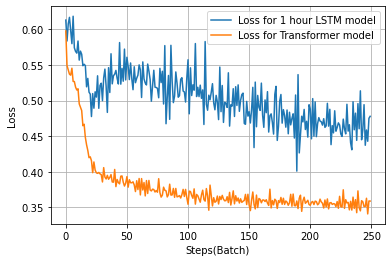

In [74]:
epochs = 250
hidden_size = 1000
num_classes = 1
feature_num = 10
predict_period=classification_x_train.shape[1]
input_size=predict_period*feature_num
batch_size=200

classification_model = ClassificationlNet(input_size, hidden_size, num_classes).cuda()
criterionCE = nn.BCELoss().cuda()
classification_optimizer = torch.optim.Adam(classification_model.parameters(), lr=0.0001)

train_loader = DataLoader(classification_x_train,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(classification_x_test,batch_size=batch_size,shuffle=True)

random.seed(123)
np.random.seed(123)
torch.manual_seed(123)
classification_test_performance,classification_y_probs,classification_y_true=Classificationl_train(train_loader,
                                                                                                    test_loader,
                                                                                                    classification_optimizer,
                                                                                                    criterionCE,
                                                                                                    classification_model)

### Predict the next 30 mins data and then create the new predicted data set

In [75]:
def lstm_predict(dataloader,minutes=30,batch_size=30):
    predict_output=[]
    for i, batch_windows in enumerate(dataloader):
        if batch_windows.shape[0]!=batch_size:
            continue
        y_true = batch_windows[:,0,0].reshape(batch_size,1,1)
        predict_output_period=torch.tensor([])
        for steps in range(minutes-1):
            if steps == 0:
                inputvector = batch_windows[:,steps,1:]
                predict_data = torch.cat((y_true.cpu(),inputvector.reshape(batch_size,1,10).cpu()),dim=2)
                predict_output_period = torch.cat((predict_output_period,predict_data.reshape(batch_size,1,11).cpu()),dim=1)
            else:
                inputvector = y_pred
            y_pred = model(inputvector.cuda())
            predict_data = torch.cat((y_true.cpu(),y_pred.reshape(batch_size,1,10).cpu()),dim=2)
            predict_output_period = torch.cat((predict_output_period,predict_data.reshape(batch_size,1,11).cpu()),dim=1)
            torch.cuda.empty_cache()
        predict_output.append(torch.Tensor.cpu(predict_output_period).detach().numpy())
        model.reset()
    predict_output = torch.tensor(predict_output).cuda()
    predict_output = predict_output.reshape(-1,minutes,11)
    return(predict_output)

train_loader = DataLoader(classification_x_train.cpu(),batch_size=30,shuffle=True)
test_loader = DataLoader(classification_x_test.cpu(),batch_size=30,shuffle=True)
train_output=lstm_predict(train_loader,minutes=minutes,batch_size=30)
predict_output=lstm_predict(test_loader,minutes=minutes,batch_size=30)
print(predict_output.shape)

torch.Size([930, 30, 11])


### use the predicted dataset for classification to get the performance of the whole model

In [76]:
def practice_predict(dataset,minutes=30):
    y_preds=torch.tensor([]).cuda()
    y_trues=torch.tensor([]).cuda()
    for j, windows in enumerate(dataset):
        if windows.shape[0]!=minutes:
            continue
        inputvector = windows[:,1:].reshape(1,minutes*10)
        y_pred = classification_model(inputvector)
        y_preds=torch.cat((y_preds,y_pred))
        y_true = windows[0,0].reshape(1,1)
        y_trues=torch.cat((y_trues,y_true))
    y_probs = y_preds.clone().detach()
    performance=performance_score(y_preds,y_trues)
    return(performance,y_preds,y_trues,y_probs)
predict_loss_transformer = []
batch_size=30
print("Performance score on test data set:")
predict_accuracy_score,y_preds,y_trues,y_probs = practice_predict(predict_output,minutes=minutes)
print("\nPerformance score on train data set:")
train_accuracy_score,train_y_preds,train_y_trues,train_y_probs = practice_predict(train_output,minutes=minutes)
print(y_preds[0:50].T)
print(y_trues[0:50].T)

Performance score on test data set:
Accuracy: 0.7784946236559139
Precision: 0.7264653326964244
Recall: 0.7189105067238244
F1-Score: 0.7224186294510386

Performance score on train data set:
Accuracy: 0.8440860215053764
Precision: 0.7877321502812906
Recall: 0.7633470126967613
F1-Score: 0.7741560684565867
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1.,
         1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.]],
       device='cuda:0', grad_fn=<PermuteBackward0>)
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1.,
         1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
         1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.]],
       device='cuda:0')


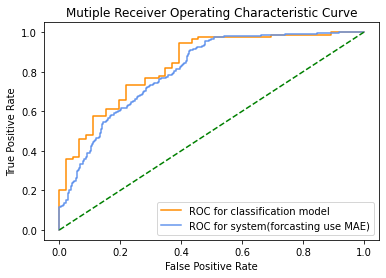

In [77]:
model_trues = torch.Tensor.cpu(y_trues).detach().numpy()
model_probs = torch.Tensor.cpu(y_probs).detach().numpy()
model_clas_probs = torch.Tensor.cpu(classification_y_probs).detach().numpy()
model_clas_trues = torch.Tensor.cpu(classification_y_true).detach().numpy()
fper, tper, thresholds = roc_curve(model_trues, model_probs)
fper_clas, tper_clas, thresholds = roc_curve(model_clas_trues, model_clas_probs)
fig,ax = plt.subplots()
plt.plot(fper_clas, tper_clas, color='darkorange', label="ROC for classification model")
plt.plot(fper, tper, color='cornflowerblue', label="ROC for system(forcasting use MAE)")
plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mutiple Receiver Operating Characteristic Curve')
plt.legend()
plt.show()